In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import matplotlib.image as mpimg
import os
from PIL import Image
import seaborn as sns
from sklearn.model_selection import  train_test_split
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from tensorflow.keras.applications.resnet50 import ResNet50



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
tf.test.gpu_device_name()
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


using Keras- preprocessing to manage the dataset

In [ ]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Thesis Project/Tomato Leaf Diseases/Training Set',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(256, 256))
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Thesis Project/Tomato Leaf Diseases/Validation Set/',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(256, 256))

Found 10000 files belonging to 10 classes.
Found 7000 files belonging to 10 classes.


Taking a look at the diffrenet categories

['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


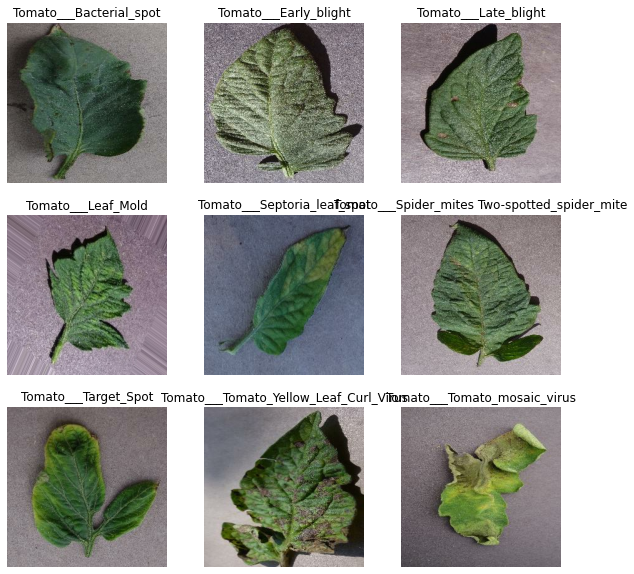

In [ ]:
class_names = train_ds.class_names
classes = train_ds.class_names

print(class_names)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")


Adding some dataAugmentation to the data set

In [ ]:

data_augmentation = tf.keras.models.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(256, 
                                                              256,
                                                              3)),
     tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
     tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Simple model with couple of dropouts.

In [ ]:
data_augmentation = tf.keras.models.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(256, 
                                                              256,
                                                              3)),
     tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.1),
     tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

model = tf.keras.models.Sequential([
    # This is the first convolution
    data_augmentation,
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(256, 256, 3)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.25),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])


adam = tf.keras.optimizers.Adam(lr=0.01, decay=1e-6)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
model.compile(
    loss='categorical_crossentropy', 
    optimizer=optimizer, 
    metrics=['accuracy']
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


two optional callbacks to customize, i prefer using the Checkpoint one here.

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if logs.get('accuracy') is not None and logs.get('accuracy') > 0.985:
      print("\n reached 98.5% accuracy so canceling training!")
      self.model.stop_training=True

In [8]:
epochs = 100
filepath="CNNweights.best.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
#callbacks=myCallback()
history = model.fit(train_ds, batch_size=32, epochs=epochs,
validation_data=validation_ds,callbacks=callbacks_list)

Epoch 1/100
313/313 [==============================] - ETA: 0s - loss: 2.2448 - accuracy: 0.1576
Epoch 1: val_accuracy improved from -inf to 0.23286, saving model to CNNweights.best.hdf5
313/313 [==============================] - 1992s 6s/step - loss: 2.2448 - accuracy: 0.1576 - val_loss: 2.1108 - val_accuracy: 0.2329
Epoch 2/100
313/313 [==============================] - ETA: 0s - loss: 1.8082 - accuracy: 0.3685
Epoch 2: val_accuracy improved from 0.23286 to 0.50214, saving model to CNNweights.best.hdf5
313/313 [==============================] - 73s 231ms/step - loss: 1.8082 - accuracy: 0.3685 - val_loss: 1.6144 - val_accuracy: 0.5021
Epoch 3/100
313/313 [==============================] - ETA: 0s - loss: 1.4729 - accuracy: 0.4933
Epoch 3: val_accuracy did not improve from 0.50214
313/313 [==============================] - 74s 236ms/step - loss: 1.4729 - accuracy: 0.4933 - val_loss: 1.8356 - val_accuracy: 0.4326
Epoch 4/100
313/313 [==============================] - ETA: 0s - loss: 1.2

0.973 accuracy on val set! thats amazing! 

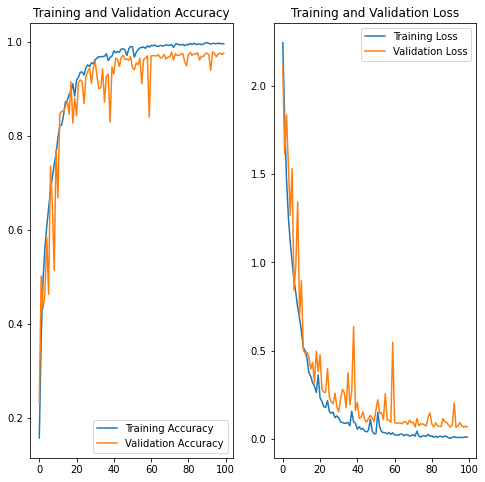

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Loading the best Model from training!

In [10]:
model.save('saved_model/my_model')
model.save('/content/drive/MyDrive/Thesis Project/Tomato Leaf Diseases/Model/my_model')

new_model = tf.keras.models.load_model(filepath)
new_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     73856     
                                                                 
 dropout (Dropout)           (None, 125, 125, 128)     0         
                                                      

In [11]:
converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
tflite_model = converter.convert()

# Save the model.
with open('CNNmodel.tflite', 'wb') as f:
  f.write(tflite_model)

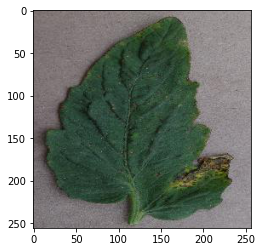

the predicted label is: Tomato___Bacterial_spot
 the model is sure about it in :[0.9997743]


In [12]:
#image='/kaggle/input/TomatoLeaf/a.png'
#image='/kaggle/input/TomatoLeaf/4a52febc9b1b81772f71572702326631.jpg'
image='/content/drive/MyDrive/Thesis Project/Tomato Leaf Diseases/Validation Set/Tomato___Bacterial_spot/image (1001).JPG'



img = tf.keras.preprocessing.image.load_img(
    image, target_size=(256, 256)
)
plt.imshow(img)
plt.show()
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batc
# pred=new_model.predict_classes(img_array)
pred = np.argmax(model.predict(img_array), axis=-1)

print(f'the predicted label is: {class_names[int(pred)]}')
print(f' the model is sure about it in :{new_model.predict(img_array)[0][pred]}')


plt.show()



showing some pictures from the category that was predicted

Tomato___Bacterial_spot


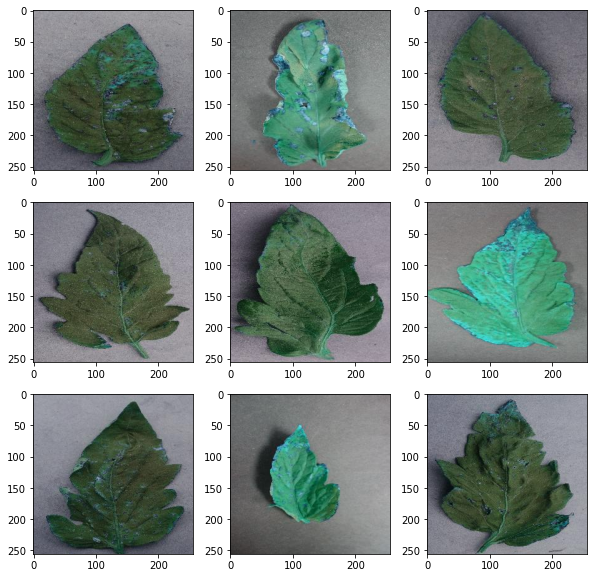

In [15]:
plt.figure(figsize=(10, 10))

pred=(int(pred))
print(class_names[pred])
path = f"/content/drive/MyDrive/Thesis Project/Tomato Leaf Diseases/Training Set/{class_names[pred]}/"   
import random
pics=[]
for r, d, f in os.walk(path):
    for file in f:
        pics.append(os.path.join(r, file))
        
for i in range(0,9):
    plt.subplot(331+i)
    img= cv2.imread(pics[random.randint(0, 600)])
    plt.imshow(img)
    
plt.show()
          

Trying out Resnet50 *not finished yet*

In [ ]:
ResNetModel = ResNet50(weights=None,input_shape=(256,256,3),include_top=False)
for layer in ResNetModel.layers:
  layer.trainable=False
  
# Print the model summary
#ResNetModel.summary()

In [ ]:
from tensorflow.keras import Model

last_layer = ResNetModel.get_layer('conv5_block3_out')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(10,activation='softmax')(x)           

ResNetModel = Model(ResNetModel.input, x) 


ResNetModel.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)
#ResNetModel.summary()

last layer output shape:  (None, 8, 8, 2048)


In [ ]:
epochs=50
filepath="RESNETweights.best.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = ResNetModel.fit(train_ds, batch_size=32, epochs=epochs,
validation_data=validation_ds,callbacks=callbacks_list)

Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 168.6520 - accuracy: 0.2985
Epoch 1: val_accuracy improved from -inf to 0.35471, saving model to RESNETweights.best.hdf5
313/313 [==============================] - 75s 226ms/step - loss: 168.6520 - accuracy: 0.2985 - val_loss: 108.0736 - val_accuracy: 0.3547
Epoch 2/50
313/313 [==============================] - ETA: 0s - loss: 72.8119 - accuracy: 0.4469
Epoch 2: val_accuracy improved from 0.35471 to 0.49043, saving model to RESNETweights.best.hdf5
313/313 [==============================] - 69s 219ms/step - loss: 72.8119 - accuracy: 0.4469 - val_loss: 48.8460 - val_accuracy: 0.4904
Epoch 3/50
313/313 [==============================] - ETA: 0s - loss: 67.0687 - accuracy: 0.4763
Epoch 3: val_accuracy improved from 0.49043 to 0.51071, saving model to RESNETweights.best.hdf5
313/313 [==============================] - 69s 219ms/step - loss: 67.0687 - accuracy: 0.4763 - val_loss: 48.0299 - val_accuracy: 0.5107
Epoch 4/50
31

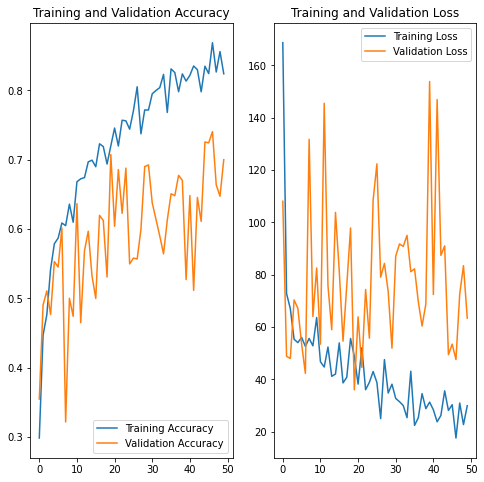

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(ResNetModel)
tflite_model = converter.convert()

# Save the model.
with open('RESNETmodel.tflite', 'wb') as f:
  f.write(tflite_model)

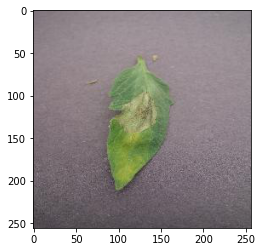

the predicted label is: Tomato___Late_blight
 the model is sure about it in :[1.]


In [ ]:
#image='/kaggle/input/TomatoLeaf/a.png'
#image='/kaggle/input/TomatoLeaf/4a52febc9b1b81772f71572702326631.jpg'
image='/content/drive/MyDrive/Thesis Project/Tomato Leaf Diseases/Validation Set/Tomato___Late_blight/image (1000).JPG'



img = tf.keras.preprocessing.image.load_img(
    image, target_size=(256, 256)
)
plt.imshow(img)
plt.show()
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batc
# pred=ResNetModel.predict_classes(img_array)
pred = np.argmax(model.predict(img_array), axis=-1)
print(f'the predicted label is: {class_names[int(pred)]}')
print(f' the model is sure about it in :{ResNetModel.predict(img_array)[0][pred]}')


plt.show()



In [ ]:
plt.figure(figsize=(10, 10))

pred=(int(pred))
print(class_names[pred])
path = f"../input/tomato-leaf-disease/Tomato Leaf Diseases/Training Set/{class_names[pred]}/"   
import random
pics=[]
for r, d, f in os.walk(path):
    for file in f:
        pics.append(os.path.join(r, file))
        
for i in range(0,9):
    plt.subplot(331+i)
    img= cv2.imread(pics[random.randint(0, 999)])
    plt.imshow(img)
    
plt.show()
          